# Transfer Learning and Gender Classification
Before running this script, make sure to upload weights for the truncated architecture either to Drive or /content/ and modify the corresponding file path when needed.

In [ ]:
#mount drive to load weights (no need to mount if upload weights directly to \content\)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# Data Preprocessing

In [ ]:
#Download tar file
!wget https://s3.amazonaws.com/matroid-web/datasets/agegender_cleaned.tar.gz

--2020-08-16 04:37:21--  https://s3.amazonaws.com/matroid-web/datasets/agegender_cleaned.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.115.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.115.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252630873 (241M) [application/x-tar]
Saving to: ‘agegender_cleaned.tar.gz.1’

agegender_cleaned.t 100%[===================>] 240.93M  44.2MB/s    in 5.6s    

2020-08-16 04:37:27 (43.1 MB/s) - ‘agegender_cleaned.tar.gz.1’ saved [252630873/252630873]



In [ ]:
#unzip
!tar --gunzip --extract --verbose --file=agegender_cleaned.tar.gz

Streaming output truncated to the last 5000 lines.
combined/aligned/56_F/landmark_aligned_face.781.12091884896_28cfc74e8c_o.jpg
combined/aligned/56_F/landmark_aligned_face.1949.8809486662_75784bf887_o.jpg
combined/aligned/56_F/nm0001122_rm1038472704_1958-1-26_2014.jpg
combined/aligned/56_F/landmark_aligned_face.1936.10335949655_98b2a4a3d3_o.jpg
combined/aligned/56_F/landmark_aligned_face.2110.11309148494_362e8423da_o.jpg
combined/aligned/56_F/landmark_aligned_face.1222.11838170535_88597a433d_o.jpg
combined/aligned/56_F/landmark_aligned_face.2110.11318525573_e515540c83_o.jpg
combined/aligned/56_F/landmark_aligned_face.752.10162091143_050bb497ea_o.jpg
combined/aligned/56_F/landmark_aligned_face.360.9730089538_c7245c51fb_o.jpg
combined/aligned/56_F/nm0219136_rm3523779072_1946-4-21_2002.jpg
combined/aligned/56_F/landmark_aligned_face.362.11838021936_882c10037a_o.jpg
combined/aligned/56_F/landmark_aligned_face.602.11850638033_1a947d9df4_o.jpg
combined/aligned/56_F/nm0001634_rm4053107968_195

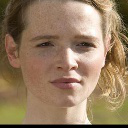

In [ ]:
import PIL
import pathlib

#view some images
data_dir = pathlib.Path('/content/combined/aligned/')
females = list(data_dir.glob('25_F/*'))
PIL.Image.open(str(females[10]))

In [ ]:
#samples num_samples number of images from each folder in the dataset directory and appends it to file_paths and labels
def subsample_from_folder(data_dir, num_samples, file_paths, labels):
  for i in range(70):
    files_in_fold_M = [str(file) for file in list(data_dir.glob(str(i+1).zfill(2) + '_M/*'))]
    files_in_fold_F = [str(file) for file in list(data_dir.glob(str(i+1).zfill(2) + '_F/*'))]

    size_M = len(list(data_dir.glob(str(i+1).zfill(2) + '_M/*')))
    random_labels_M = random.sample(range(size_M), min(num_samples, size_M))
    for label in random_labels_M:
      file_paths.append(files_in_fold_M[label])
      labels.append(0)

    size_F = len(list(data_dir.glob(str(i+1).zfill(2) + '_F/*')))
    random_labels_F = random.sample(range(size_F), min(num_samples, size_F))
    for label in random_labels_F:
      file_paths.append(files_in_fold_F[label])
      labels.append(1)


In [ ]:
#construct a training list along with label by sampling from dataset
import cv2
import numpy as np
np.random.seed(0)
import random
random.seed(0) 

file_paths = []
labels = []
num_samples = 20

#aligned
data_dir = pathlib.Path('/content/combined/aligned')
subsample_from_folder(data_dir, num_samples, file_paths, labels)

In [ ]:
print(len(file_paths))

2800


In [ ]:
#combine file paths and labels in order to split in train and test sets
file_paths = np.array(file_paths).reshape(len(file_paths), 1)
labels = np.array(labels).reshape(len(file_paths), 1)
merged_data = np.concatenate((file_paths, labels), axis=1)
print(merged_data.shape)
print("pre shuffle", merged_data)

#shuffle
np.random.shuffle(merged_data)
print("post shuffle", merged_data)

#index
end_train = int(len(file_paths)*0.60)
end_vald = int(len(file_paths)*0.60) + int(len(file_paths)*0.20)

#extract train, validation, and test sets
train = merged_data[:end_train,:]
valid = merged_data[end_train:end_vald,:]
test = merged_data[end_vald:,:]

print(len(train))
print(len(valid))
print((len(test)))

(2800, 2)
pre shuffle [['/content/combined/aligned/01_M/landmark_aligned_face.911.11840661685_39263eb476_o.jpg'
  '0']
 ['/content/combined/aligned/01_M/landmark_aligned_face.84.9657597973_5832ece8cc_o.jpg'
  '0']
 ['/content/combined/aligned/01_M/landmark_aligned_face.911.11849208293_3678bf17be_o.jpg'
  '0']
 ...
 ['/content/combined/aligned/70_F/11772430_1938-04-14_2008.jpg' '1']
 ['/content/combined/aligned/70_F/1966498_1941-07-01_2011.jpg' '1']
 ['/content/combined/aligned/70_F/nm0001046_rm3004348928_1941-4-14_2011.jpg'
  '1']]
post shuffle [['/content/combined/aligned/35_F/nm0000569_rm3025111808_1972-9-27_2008.jpg'
  '1']
 ['/content/combined/aligned/05_F/landmark_aligned_face.17.9931510656_48d12483fb_o.jpg'
  '1']
 ['/content/combined/aligned/07_M/nm2924626_rm1326618112_1990-12-28_2002.jpg'
  '0']
 ...
 ['/content/combined/aligned/42_M/28238528_1913-12-21_1956.jpg' '0']
 ['/content/combined/aligned/66_M/422137_1947-11-13_2014.jpg' '0']
 ['/content/combined/aligned/69_M/1202722_19

In [ ]:
#replace file paths with numpy images
images_train = []
labels_train = []

images_valid = []
labels_valid = []

images_test = []
labels_test = []

WIDTH, HEIGHT = 224, 224

for row in train:
  im = cv2.imread(row[0])

  im = cv2.resize(im,  (WIDTH, HEIGHT))
  images_train.append(im)
  labels_train.append(float(row[1]))

for row in valid:
  im = cv2.imread(row[0])

  im = cv2.resize(im,  (WIDTH, HEIGHT))
  images_valid.append(im)
  labels_valid.append(float(row[1]))

for row in test:
  im = cv2.imread(row[0])

  im = cv2.resize(im,  (WIDTH, HEIGHT))
  images_test.append(im)
  labels_test.append(float(row[1]))

print(np.array(images_train).shape)

(1680, 224, 224, 3)


In [ ]:
#compute mean training image for normalization
mean_img = np.mean(images_train, axis=0)
print(mean_img.shape)

norm_images_train = np.array(images_train) - mean_img
norm_images_valid = np.array(images_valid) - mean_img
norm_images_test = np.array(images_test) - mean_img

print(norm_images_train.shape)
print(norm_images_valid.shape)
print(norm_images_test.shape)

(224, 224, 3)
(1680, 224, 224, 3)
(560, 224, 224, 3)
(560, 224, 224, 3)


In [ ]:
#port training, validation, and test datasets into tf.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((norm_images_train, labels_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((norm_images_valid, labels_valid))

BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

for elem in train_dataset:
  print(elem)

Streaming output truncated to the last 5000 lines.
         [  6.64702381,  19.03809524,  49.98630952],
         [  6.8172619 ,  19.18333333,  50.3       ],
         [  6.90654762,  19.24166667,  50.48214286]],

        [[ 55.8125    ,  56.87678571,  51.78988095],
         [ 50.60416667,  51.5375    ,  46.48630952],
         [ 43.17380952,  43.95416667,  38.91190476],
         ...,
         [  5.6047619 ,  17.91964286,  48.79940476],
         [  9.8547619 ,  21.11904762,  52.225     ],
         [ 10.9702381 ,  23.18571429,  54.41428571]],

        ...,

        [[ 86.17440476,  89.41071429,  85.39404762],
         [ 84.17440476,  87.32202381,  83.3327381 ],
         [ 80.13154762,  83.11488095,  79.17797619],
         ...,
         [ -4.76547619,  -4.19702381,  46.23511905],
         [-10.22916667,  -9.80952381,  40.77738095],
         [-13.94702381, -13.60535714,  37.06964286]],

        [[ 78.2422619 ,  81.4375    ,  77.52678571],
         [ 68.26369048,  71.41190476,  67.50238095],


In [ ]:
#pre-fetch batches to speed up
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Building

In [ ]:
#Reconstruct VGG Face Descriptor
base_model = models.Sequential()
base_model.add(layers.Conv2D(64, (3, 3), padding= "same", activation='relu', input_shape=(224, 224, 3)))
base_model.add(layers.Conv2D(64, (3, 3),padding= "same", activation='relu'))
base_model.add(layers.MaxPooling2D(2, 2))
base_model.add(layers.Conv2D(128, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(128, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.MaxPooling2D(2, 2))
base_model.add(layers.Conv2D(256, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(256, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(256, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.MaxPooling2D(2, 2))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.MaxPooling2D(2, 2))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.Conv2D(512, (3, 3), padding= "same", activation='relu'))
base_model.add(layers.MaxPooling2D(2, 2))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [ ]:
#Load weights - replace with own path if uploading weights directly
src_path = "/content/drive/My Drive/weights_truncated.h5"
base_model.load_weights(src_path)
weights, biases = base_model.layers[0].get_weights()

#check that weights have been loaded
print(weights)
base_model.summary()

[[[[ 0.02418656  0.05323381 -0.01099186 ... -0.04440259  0.01828277
    -0.1007985 ]
   [ 0.07218545  0.16628309 -0.0017996  ... -0.05000973  0.11803459
    -0.08741822]
   [ 0.06460536 -0.13839327  0.0071591  ...  0.08747088 -0.19605596
    -0.06391917]]

  [[-0.00369529  0.04856608 -0.00928699 ... -0.03097921  0.02612239
    -0.06614216]
   [ 0.03982019  0.15625596 -0.00034941 ... -0.03360835  0.12642314
    -0.0468199 ]
   [ 0.03615239 -0.14774987  0.00970824 ...  0.10209309 -0.18954486
    -0.03028544]]

  [[-0.05865374  0.02274405 -0.01561985 ... -0.03965216  0.023479
    -0.0454097 ]
   [-0.02589355  0.13388738 -0.00584445 ... -0.04295931  0.12734956
    -0.02332257]
   [-0.02391577 -0.16854998  0.00030793 ...  0.09089436 -0.1869799
    -0.01098787]]]


 [[[ 0.09105629  0.06526305  0.03294564 ...  0.01903132  0.03626859
     0.00122249]
   [ 0.15534328  0.16949905  0.0533126  ...  0.03873022  0.1329108
     0.0454465 ]
   [ 0.14536376 -0.14089675  0.0583757  ...  0.17087379 -0.18

In [ ]:
#freeze weights
base_model.trainable = False
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [ ]:
#Add classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
fc_1 = tf.keras.layers.Dense(32, activation="relu")
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = fc_1(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
new_model = tf.keras.Model(inputs, outputs)

new_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 14,731,137
Trainable params: 16,449
Non-trainable params: 14,714,688
_____________________________________

# Training

In [ ]:
#compile new model
base_learning_rate = 0.001
new_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
#train new model for 10 epochs
epochs=10
history = new_model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/10
84/84 [==============================] - 1115s 13s/step - loss: 1.0003 - accuracy: 0.7381 - val_loss: 0.3322 - val_accuracy: 0.8411
Epoch 2/10
84/84 [==============================] - 1110s 13s/step - loss: 0.3122 - accuracy: 0.8631 - val_loss: 0.2858 - val_accuracy: 0.8732
Epoch 3/10
84/84 [==============================] - 1114s 13s/step - loss: 0.2505 - accuracy: 0.8899 - val_loss: 0.2484 - val_accuracy: 0.8786
Epoch 4/10
84/84 [==============================] - 1114s 13s/step - loss: 0.2075 - accuracy: 0.9071 - val_loss: 0.2294 - val_accuracy: 0.8768
Epoch 5/10
84/84 [==============================] - 1115s 13s/step - loss: 0.1854 - accuracy: 0.9143 - val_loss: 0.2411 - val_accuracy: 0.8893
Epoch 6/10
84/84 [==============================] - 1112s 13s/step - loss: 0.1656 - accuracy: 0.9268 - val_loss: 0.2204 - val_accuracy: 0.8875
Epoch 7/10
84/84 [==============================] - 1113s 13s/step - loss: 0.1362 - accuracy: 0.9429 - val_loss: 0.2059 - val_accuracy: 0.9018

In [ ]:
#save model weights and architecture
new_model.save("weights_arch_transfer_model")

INFO:tensorflow:Assets written to: weights_arch_transfer_model/assets


In [ ]:
#save model weights and architecture
new_model.save("weights_arch_transfer_model_h5.h5")

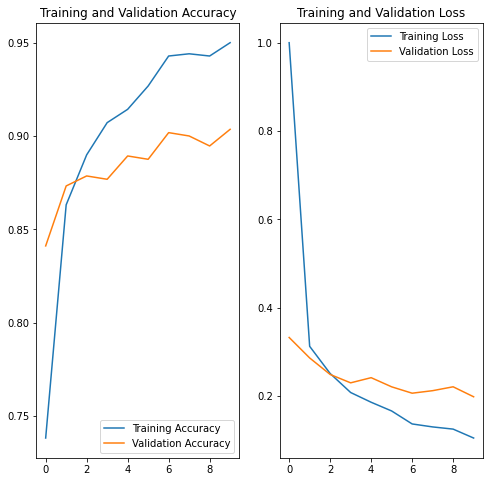

In [ ]:
#plot learning curves - note because I used dropout, the network performs differently on training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation

Overall Metrics

In [ ]:
# Overall
test_dataset_overall = tf.data.Dataset.from_tensor_slices((norm_images_test, labels_test))
test_dataset_overall = test_dataset_overall.batch(20)

In [ ]:
#make predictions on entire test set images
predictions = new_model.predict(test_dataset_overall, verbose=1).flatten()
#apply sigmoid since net returns logit
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

28/28 [==============================] - 272s 10s/step


In [ ]:
#compute metric
m = tf.keras.metrics.Accuracy()
m.update_state(labels_test, predictions)
acc_overall = m.result().numpy()
print("Overall Test Accuracy: ", acc_overall)

m = tf.keras.metrics.Recall()
m.update_state(labels_test, predictions)
recall_overall = m.result().numpy()
print("Overall Test Recall: ", recall_overall)

m = tf.keras.metrics.Precision()
m.update_state(labels_test, predictions)
prec_overall = m.result().numpy()
print("Overall Test Precision: ", prec_overall)

m = tf.keras.metrics.AUC()
m.update_state(labels_test, predictions)
auc_overall = m.result().numpy()
print("Overall Test AUC: ", auc_overall)

TN = np.count_nonzero((np.array(predictions - 1)) * (np.array(labels_test) - 1))
FP = np.count_nonzero(np.array(predictions) * (np.array(labels_test) - 1))
print("Overall Test Specificity: ", TN/(TN+FP))


Overall Test Accuracy:  0.9267857
Overall Test Recall:  0.93233085
Overall Test Precision:  0.9151291
Overall Test AUC:  0.9270498
Overall Test Specificity:  0.9217687074829932


 Male Metrics

In [ ]:
#extract only male images from testing set
normalized_test_images_male = np.array([img for (index, img) in enumerate(norm_images_test) if labels_test[index] == 0])
print(normalized_test_images_male.shape)
labels_test_male = np.array([label for label in labels_test if label == 0])
print(labels_test_male.shape)
test_dataset_male = tf.data.Dataset.from_tensor_slices((normalized_test_images_male, labels_test_male))
test_dataset_male = test_dataset_male.batch(20)

(294, 224, 224, 3)
(294,)


In [ ]:
#make predictions on male images of test set
predictions_male = new_model.predict(test_dataset_male, verbose=1).flatten()
#apply sigmoid since net returns logit
predictions_male = tf.nn.sigmoid(predictions_male)
predictions_male = tf.where(predictions_male < 0.5, 0, 1)

In [ ]:
#compute metrics
m = tf.keras.metrics.Accuracy()
m.update_state(labels_test_male, predictions_male)
acc_male = m.result().numpy()
print("Male Test Accuracy: ", acc_male)

m = tf.keras.metrics.Recall()
m.update_state(labels_test_male, predictions_male)
recall_male = m.result().numpy()
print("Male Test Recall: ", recall_male)

m = tf.keras.metrics.Precision()
m.update_state(labels_test_male, predictions_male)
prec_male = m.result().numpy()
print("Male Test Precision: ", prec_male)

m = tf.keras.metrics.AUC()
m.update_state(labels_test_male, predictions_male)
auc_male = m.result().numpy()
print("Male Test AUC: ", auc_male)

TN = np.count_nonzero((np.array(predictions_male - 1)) * (np.array(labels_test_male) - 1))
FP = np.count_nonzero(np.array(predictions_male) * (np.array(labels_test_male) - 1))
print("Male Test Specificity: ", TN/(TN+FP))

Male Test Accuracy:  0.9217687
Male Test Recall:  0.0
Male Test Precision:  0.0
Male Test AUC:  0.0
Male Test Specificity:  0.9217687074829932


Female Metrics

In [ ]:
#extract only female images from testing set
normalized_test_images_female = np.array([img for (index, img) in enumerate(norm_images_test) if labels_test[index] == 1])
print(normalized_test_images_female.shape)
labels_test_female = np.array([label for label in labels_test if label == 1])
print(labels_test_female.shape)
test_dataset_female = tf.data.Dataset.from_tensor_slices((normalized_test_images_female, labels_test_female))
test_dataset_female = test_dataset_female.batch(20)

(266, 224, 224, 3)
(266,)


In [ ]:
#make predictions on male images of test set
predictions_female = new_model.predict(test_dataset_female, verbose=1).flatten()
#apply sigmoid since net returns logit
predictions_female = tf.nn.sigmoid(predictions_female)
predictions_female = tf.where(predictions_female < 0.5, 0, 1)

In [ ]:
#compute metrics
m = tf.keras.metrics.Accuracy()
m.update_state(labels_test_female, predictions_female)
acc_female = m.result().numpy()
print("Female Test Accuracy: ", acc_female)

m = tf.keras.metrics.Recall()
m.update_state(labels_test_female, predictions_female)
recall_female = m.result().numpy()
print("Female Test Recall: ", recall_female)

m = tf.keras.metrics.Precision()
m.update_state(labels_test_female, predictions_female)
prec_female = m.result().numpy()
print("Female Test Precision: ", prec_female)

m = tf.keras.metrics.AUC()
m.update_state(labels_test_female, predictions_female)
auc_female = m.result().numpy()
print("Female Test AUC: ", auc_female)

Female Test Accuracy:  0.93233085
Female Test Recall:  0.93233085
Female Test Precision:  1.0
Female Test AUC:  0.0
